In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.constants as const
import os, sys, time
import astropy.units as u
from fractions import Fraction

In [100]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

# Directory Names

In [101]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise as SnN
import StrainandNoise_v2 as SnN_v2
import SNRcalc as SNc
import SNRcalc_v2 as SNc_v2
import SNRcalc_v3 as SNc_v3

#Save suffix for SNR and Sample data files
save_version = '_noGWB_1.dat'

In [102]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

# Constants and Initial Parameters

In [165]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
            'Tobs' - Observation Time
        
        LISA ONLY:
            GLOBAL LISA:
                'L' - Armlength
            NEIL ONLY:
                'S_acc' - Acceleration Noise
                'S_oms' - Optical Metrology
            MARTIN ONLY:
                'S_sci'
                'S_loc'
                'S_other'
                'S_acc_low_knee'
                'S_acc_high_knee'
                'S_acc_low'
                'S_acc_high'
            ESA ONLY:
                'S_acc_low_knee'
                 'S_acc_high_knee'
                 'S_oms_knee'
                 'S_acc'
                 'S_ims'
        PTAs ONLY:
            'Np' - Number of Pulsars
            'rms' - Timing Error RMS
            'dt' - cadence
'''

var_y = 'z' #Variable on y-axis

sampleRate_y = 100 #Number of SNRMatrix rows

var_x = 'M' #Variable on x-axis

sampleRate_x = 100 #Number of SNRMatrix columns

#Selects which noise curve: 0 is Neil Cornish's,
# 							1 is the 2016 proposal,
#							2 is Einstein Telescope, 
#							3 is aLIGO, 
#							4 is NANOGrav 15yr,
#							5 is SKA (2030s),
#							anything else is the L3 proposal
model = 1

#For use in the SNR of the diff EOB waveforms
# 0 is diff0002
# 1 is diff0114
# 2 is diff0178
# 3 is diff0261
# 4 is diff0303
# anything else is not the EOB waveform
diff_model = 20
if diff_model == 0:
    diff_name = 'diff0002'
elif diff_model == 1:
    diff_name = 'diff0114'
elif diff_model == 2:
    diff_name = 'diff0178'
elif diff_model == 3:
    diff_name = 'diff0261'
elif diff_model == 4:
    diff_name = 'diff0303'
#TODO: make general intake of some f,and sqrt(S_n_f)

# Source Selection

In [166]:
def Get_Source(model):
    source = SnN_v2.BlackHoleBinary()
    if model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 4 or model == 5:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10

    source.Set_Mass(M,M_min,M_max)
    
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0
    
    source.Set_MassRatio(q,q_min,q_max)

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    source.Set_Chi1(chi1,chi_min,chi_max)
    source.Set_Chi2(chi2,chi_min,chi_max)
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source.Set_Redshift(z,z_min,z_max)

    source.nfreqs = int(1e3)   #Sample rate of strain/Transfer function frequencies
    
    #Doesn't Really work yet
    inc = 0.0
    inc_min = 0.0
    inc_max = 0.0
    source.Set_Inclination(inc,inc_min,inc_max)
    return source

# Model Selection

In [167]:
def Get_Model(model):
    if model == 0: #Robson,Cornish,and Liu 2018, LISA (https://arxiv.org/pdf/1803.01944.pdf)
        SNR_save_name = 'LISA_Neil_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_Neil_Samples' + save_version
        save_location = load_directory + 'LISA_Neil/SNRFiles/'
        
        instrument = SnN_v2.SpaceBased('Neil_LISA')
        instrument.Default_Setup()
        instrument.Set_A_acc(3e-15*u.m/u.s/u.s)
        instrument.Set_A_IMS(1.5e-11*u.m)
        instrument.Get_approxTransferFunction()
        instrument.Get_Strain()
        instrument.Set_f_opt()

    elif model == 1: #Martin 2016: LISA Calculation without pathfinder correction (2016 model)
        SNR_save_name = 'LISA_Other_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_Other_Samples' + save_version
        save_location = load_directory + 'LISA_Other/SNRFiles/'
        
        instrument = SnN_v2.SpaceBased('Martin_LISA')
        
        T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
        T_obs_min = 1*u.yr.to('s')*u.s
        T_obs_max = 10*u.yr.to('s')*u.s
        instrument.Set_T_obs(T_obs,T_obs_min,T_obs_max)
        
        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        instrument.Set_L(L,L_min,L_max)

        A_sci = 8.9e-12*u.m
        A_loc = 1.7e-12*u.m
        A_other = 2e-12*u.m
        A_IMS = np.sqrt(A_sci**2+2*A_loc**2+A_other**2)
        instrument.Set_A_IMS(A_IMS)
        instrument.Set_f_IMS_break(2.*u.mHz.to('Hz')*u.Hz)

        f_acc_break_low = 30.*u.uHz.to('Hz')*u.Hz
        instrument.Set_f_acc_break_low(f_acc_break_low)
        
        f_acc_break_high = 0.1*u.mHz.to('Hz')*u.Hz
        instrument.Set_f_acc_break_high(f_acc_break_high)
        
        A_acc_low = 1.8e-14*u.m/u.s/u.s
        A_acc_high = 3e-15*u.m/u.s/u.s
        instrument.Set_A_acc(A_acc_high)
        
        instrument.Get_TransferFunction()
        instrument.Background = True
        instrument.Get_Strain()
        instrument.Set_f_opt()

    elif model == 2: #Einstein Telescope
        SNR_save_name = 'ET_SNR_Matrix' + save_version
        Sample_save_name = 'ET_Samples' + save_version
        save_location = load_directory + 'EinsteinTelescope/SNRFiles/'
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name

        instrument = SnN_v2.GroundBased('ET')
        
        Tobs = 4*u.yr.to('s')*u.s #Observing time in seconds
        Tobs_min = 1*u.yr.to('s')*u.s
        Tobs_max = 10*u.yr.to('s')*u.s
        
        instrument.Set_T_obs(Tobs,T_obs_min=Tobs_min,T_obs_max=Tobs_max)
        instrument.Get_Strain(load_location)
        instrument.Set_f_opt()

    elif model == 3: #aLIGO
        SNR_save_name = 'aLIGO_SNR_Matrix' + save_version
        Sample_save_name = 'aLIGO_Samples' + save_version
        save_location = load_directory + 'aLIGO/SNRFiles/'
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name

        instrument = SnN_v2.GroundBased('aLIGO')
        
        Tobs = 4*u.yr.to('s')*u.s #Observing time in seconds
        Tobs_min = 1*u.yr.to('s')*u.s
        Tobs_max = 10*u.yr.to('s')*u.s

        instrument.Set_T_obs(Tobs,T_obs_min=Tobs_min,T_obs_max=Tobs_max)
        instrument.Get_Strain(load_location)
        instrument.Set_f_opt()

    elif model == 4: #NANOGrav 15 yr

        SNR_save_name = 'NANOGrav_SNR_Matrix' + save_version
        Sample_save_name = 'NANOGrav_Samples' + save_version
        save_location = load_directory + 'NANOGrav/SNRFiles/'
        
        instrument = SnN_v2.PTA('NANOGrav')

        ###############################################
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        Tobs = 15*u.yr.to('s')*u.s #Observing time (years->seconds)
        Tobs_min = 10*u.yr.to('s')*u.s
        Tobs_max = 30*u.yr.to('s')*u.s
        
        instrument.Set_T_obs(Tobs,T_obs_min=Tobs_min,T_obs_max=Tobs_max)

        rms = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        instrument.Set_rms(rms)
        
        Np = 18 #Number of pulsars
        instrument.Set_N_p(Np)
        
        cadence = 1/(2*u.wk.to('s')*u.s) #Avg observation cadence of 1 every 2 weeks in seconds
        instrument.Set_cadence(cadence)
        
        #instrument.Background = True
        instrument.Get_ASD()
        instrument.Get_Strain()
        instrument.Set_f_opt()
        
    elif model == 5: #SKA (2030s)

        SNR_save_name = 'SKA_SNR_Matrix' + save_version
        Sample_save_name = 'SKA_Samples' + save_version
        save_location = load_directory + 'SKA/SNRFiles/'
        
        instrument = SnN_v2.PTA('SKA')

        ###############################################
        #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
        Tobs = 15*u.yr.to('s')*u.s #Observing time (years->seconds)
        Tobs_min = 10*u.yr.to('s')*u.s
        Tobs_max = 30*u.yr.to('s')*u.s
        instrument.Set_T_obs(Tobs,T_obs_min=Tobs_min,T_obs_max=Tobs_max)
        
        rms = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        instrument.Set_rms(rms)
        
        Np = 20 #Number of pulsars
        instrument.Set_N_p(Np)
        
        cadence = 1/(u.wk.to('s')*u.s) #Avg observation cadence of 1 every week in seconds
        instrument.Set_cadence(cadence)
        
        #instrument.Background = True
        instrument.Get_ASD()
        instrument.Get_Strain()
        instrument.Set_f_opt()

    else: #L3 proposal
        SNR_save_name = 'LISA_ESA_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_ESA_Samples' + save_version
        save_location = load_directory + 'LISA_ESA/SNRFiles/'
        
        instrument = SnN_v2.SpaceBased('LISA_ESA')
        instrument.Default_Setup()

        '''
        Default Params!
        S_acc_low_knee = .4*u.mHz.to('Hz')*u.Hz
        S_acc_high_knee = 8.*u.mHz.to('Hz')*u.Hz
        S_oms_knee = 2.*u.mHz.to('Hz')*u.Hz
        S_acc = 3e-15*u.m/u.s/u.s
        S_ims = 10e-12*u.m'''
        
    return instrument

In [168]:
model = 0 #1,6
instrument_1 = Get_Model(model)
print(instrument_1.name)
model = 1
instrument_2 = Get_Model(model)
print(instrument_2.name)
model = 6
instrument_3 = Get_Model(model)
print(instrument_3.name)

Neil_LISA
Martin_LISA
LISA_ESA


In [169]:
source_1 = Get_Source(model)
source_1.Default_Setup(instrument_3)

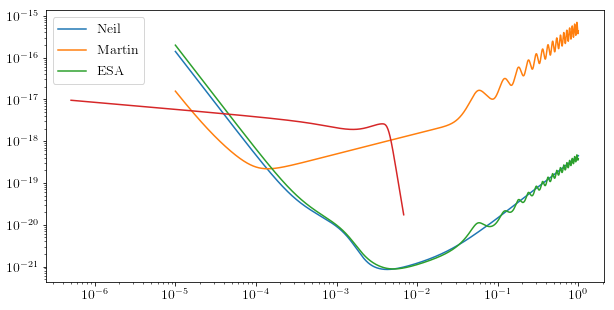

In [170]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_1.fT,instrument_1.h_n_f,label='Neil')
plt.loglog(instrument_2.fT,instrument_2.h_n_f,label='Martin')
plt.loglog(instrument_3.fT,instrument_3.h_n_f,label='ESA')
plt.loglog(source_1.f,source_1.Get_CharStrain())
plt.legend()
plt.show()

In [171]:
model = 2
instrument_1 = Get_Model(model)
model = 3
instrument_2 = Get_Model(model)

In [172]:
source_2 = Get_Source(model)
source_2.Default_Setup(instrument_2)

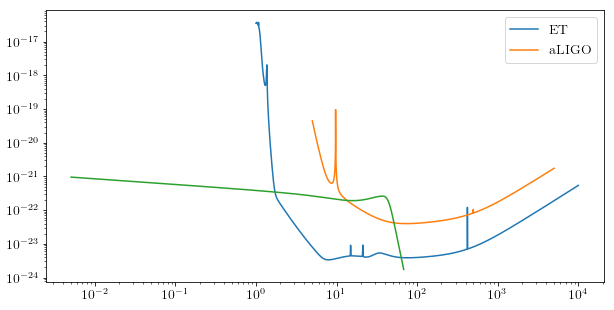

In [173]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_1.fT,np.sqrt(instrument_1.fT)*instrument_1.S_n_f_sqrt,label='ET')
plt.loglog(instrument_2.fT,np.sqrt(instrument_2.fT)*instrument_2.S_n_f_sqrt,label='aLIGO')
plt.loglog(source_2.f,source_2.Get_CharStrain())
plt.legend()
plt.show()

In [174]:
model = 4
instrument_1 = Get_Model(model)
model = 5
instrument_2 = Get_Model(model)

In [175]:
source_3 = Get_Source(model)
source_3.Default_Setup(instrument_2)

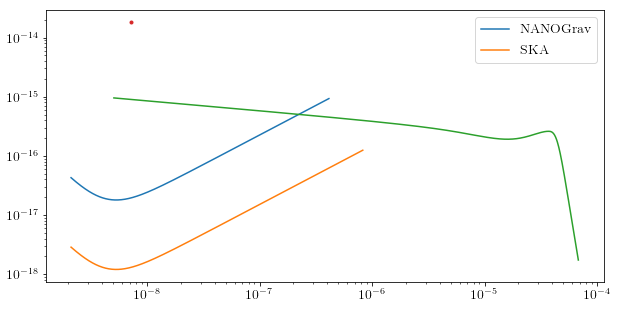

In [176]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_1.fT,instrument_1.h_n_f,label='NANOGrav')
plt.loglog(instrument_2.fT,instrument_2.h_n_f,label='SKA')
plt.loglog(source_3.f,source_3.Get_CharStrain())
plt.loglog(source_3.f_init,source_3.h_gw,'.')
plt.legend()
plt.show()

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


start = time.time()
[sample_x_orig,sample_y_orig,SNRMatrix_orig] = SNc.getSNRMatrix(source_var_dict,inst_var_dict,fT,S_n_f_sqrt,Tobs,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y,model)
end = time.time()
print(end-start)

model = 6
diff_model = 0
inst_var_dict = Get_Model(model)
source_var_dict = Get_Source(model)
[fT,S_n_f_sqrt] = SNc_v2.Model_Selection(inst_var_dict,False)
if diff_model <= 4:
    if diff_model == 0:
        diff_name = 'diff0002'
    elif diff_model == 1:
        diff_name = 'diff0114'
    elif diff_model == 2:
        diff_name = 'diff0178'
    elif diff_model == 3:
        diff_name = 'diff0261'
    elif diff_model == 4:
        diff_name = 'diff0303'
    diff_filename = diff_name + '.dat'
    diff_filelocation = top_directory + '/LoadFiles/DiffStrain/EOBdiff/' + diff_filename
    diff_data = np.loadtxt(diff_filelocation)
    diff_t = diff_data[:,0]*u.s
    diff_hp = diff_data[:,1]
    diff_hc = diff_data[:,2] 
    [diff_f,diff_h_f] = SnN.Get_hf_from_hcross_hplus(diff_t,diff_hc,diff_hp)

[diff_f,diff_h,SNRpost] = SNc_v2.calcDiffSNR(source_var_dict,fT,S_n_f_sqrt,diff_f,diff_h_f)

plt.figure(figsize=(10,5))
plt.loglog(fT,np.sqrt(fT)*S_n_f_sqrt)
plt.loglog(diff_f,diff_h)
plt.show()

In [177]:
model = 6
instrument = Get_Model(model)
source = Get_Source(model)
source.Set_Instrument(instrument)
start = time.time()
[sample_x,sample_y,SNRMatrix] = SNc_v3.getSNRMatrix(source,instrument,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

ValueError: attempt to get argmin of an empty sequence

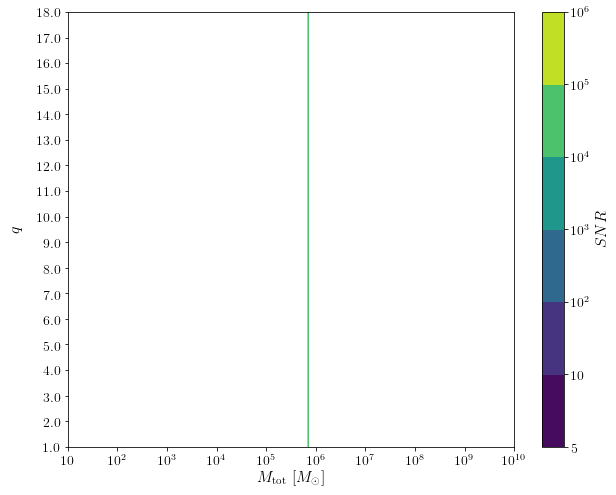

In [164]:
SNc_v3.plotSNR(source.source_var_dict,instrument.inst_var_dict,var_x,sample_x,var_y,sample_y,SNRMatrix)

In [43]:
source_var_dict = Get_Source(model)
inst_var_dict = Get_Model(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = SNc_v2.getSNRMatrix(source_var_dict,inst_var_dict,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y,diff_model)
end = time.time()
print(end-start)

x var:  M
y var:  q


/home/andrew/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


59.62806248664856


In [32]:
isitsavetime = False
figname = '/LISA_LvM.pdf'
if isitsavetime:
    figloc = fig_save_location + figname
else:
    figloc = None

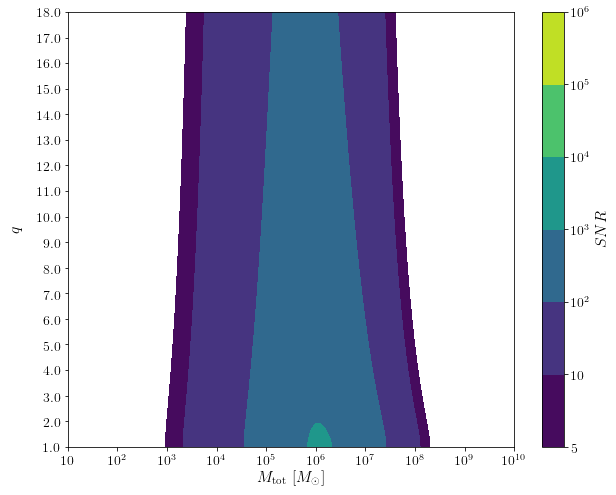

In [45]:
SNc_v2.plotSNR(source_var_dict,inst_var_dict,var_x,sample_x,var_y,sample_y,SNRMatrix,figloc=figloc)

SNc.plotSNR(source_var_dict,var_x,sample_x_orig,var_y,sample_y_orig,SNRMatrix_orig)

In [10]:
#SNc.saveSNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)

# Whole Hog creating EOB plots

x var:  M
y var:  z


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model:  LISA_ESA , EOB Model:  0  done. t = :  54.76646590232849
x var:  M
y var:  z


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model:  LISA_ESA , EOB Model:  1  done. t = :  49.24836611747742
x var:  M
y var:  z


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model:  LISA_ESA , EOB Model:  2  done. t = :  51.5205659866333
x var:  M
y var:  z


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model:  LISA_ESA , EOB Model:  3  done. t = :  53.387166023254395
x var:  M
y var:  z


/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model:  LISA_ESA , EOB Model:  4  done. t = :  51.419548988342285


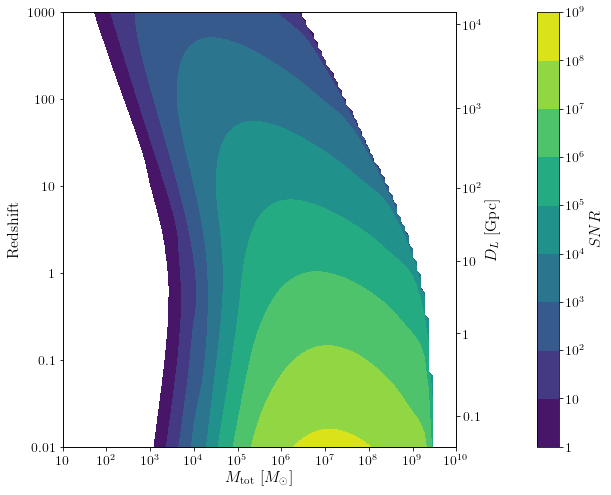

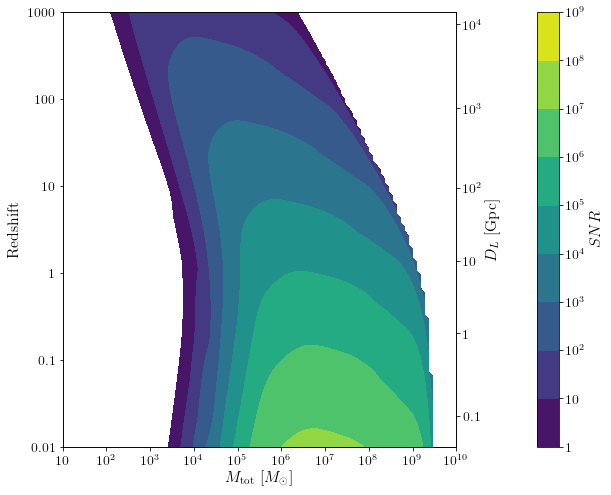

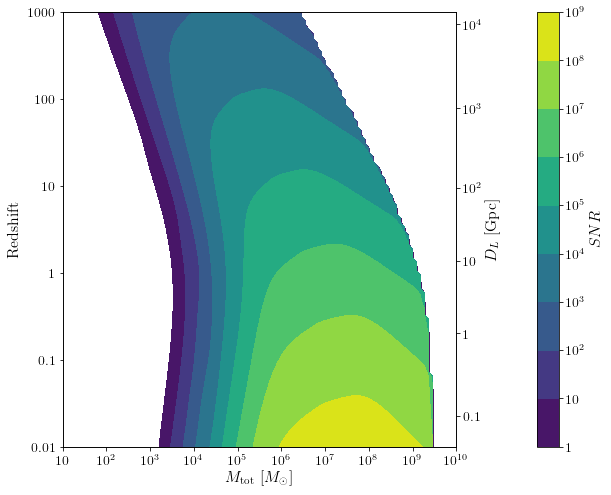

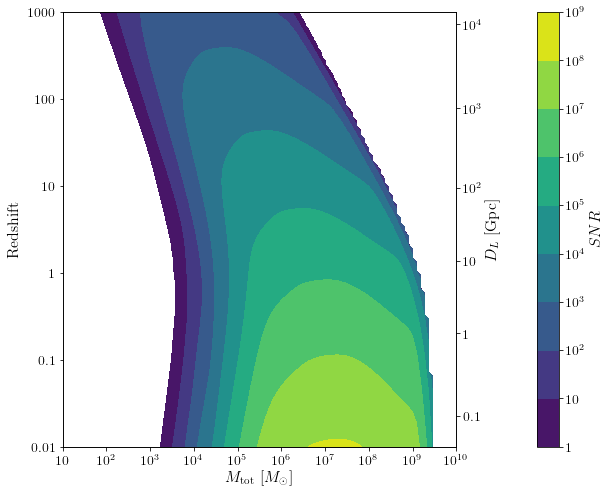

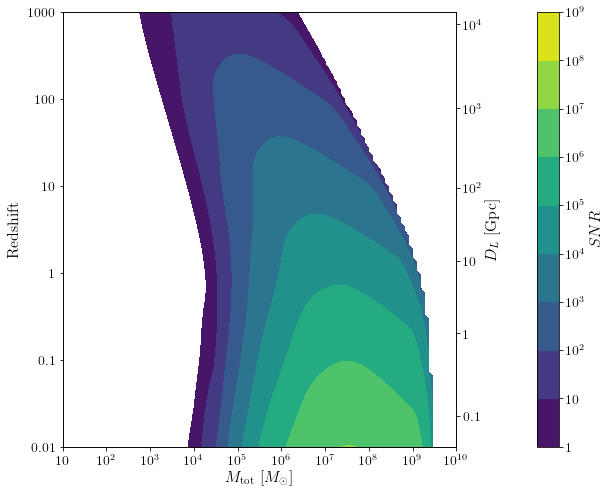

In [23]:
#wanted_models = [2,3,6]
wanted_diff_models = range(5)
#wanted_models = [2,3] #Only aLIGO and ET
wanted_models = [6] #LISA Only

diff_save_idx = splt_path.index('Research')
diff_save_location = "/".join(splt_path[0:diff_save_idx+1])
diff_save_location += '/diffEOBfigs'

if os.path.exists(diff_save_location):
    pass
else:
    os.mkdir(diff_save_location)
    
diff_save_version = '_v3'

for mod in wanted_models: #Inst model numbers we want
    inst_var_dict_mod = Get_Model(mod)
    source_var_dict_mod = Get_Source(mod)
    mod_name = list(inst_var_dict_mod.keys())[0]
    diff_save_location_mod = None
    diff_save_location_mod = diff_save_location + '/' + mod_name
    if os.path.exists(diff_save_location_mod):
        pass
    else:
        os.mkdir(diff_save_location_mod)

    for diff_mod in wanted_diff_models: #Range of diff_EOB waveforms
        if diff_mod == 0:
            diff_mod_name = '/diff0002'
        elif diff_mod == 1:
            diff_mod_name = '/diff0114'
        elif diff_mod == 2:
            diff_mod_name = '/diff0178'
        elif diff_mod == 3:
            diff_mod_name = '/diff0261'
        elif diff_mod == 4:
            diff_mod_name = '/diff0303'
            
        diff_SNR_save_name = diff_mod_name + '_SNR_Matrix' + diff_save_version + '.dat'
        diff_Sample_save_name = diff_mod_name + '_Samples' + diff_save_version + '.dat'
        diff_fig_save_name = diff_save_location_mod + diff_mod_name + diff_save_version + '.pdf'

        start = time.time()
        [sample_x,sample_y,SNRMatrix] = SNc_v2.getSNRMatrix(source_var_dict_mod,inst_var_dict_mod,\
                                                         var_x,sampleRate_x,var_y,sampleRate_y,diff_mod)
        end = time.time()
        SNc_v2.saveSNR(sample_x,sample_y,SNRMatrix,diff_save_location_mod,diff_SNR_save_name,diff_Sample_save_name)
        SNc_v2.plotSNR(source_var_dict_mod,inst_var_dict_mod,var_x,sample_x,var_y,sample_y,SNRMatrix,display=False,isitsavetime=True,figloc=diff_fig_save_name,dl_axis=True)
        print('Model: ',list(inst_var_dict_mod.keys())[0],', EOB Model: ',diff_mod,' done. t = : ',end-start)

In [39]:
Mass = 1e9
q = 1.0
z = 0.0
source_dict_tmp = {'M':{'val':Mass},
                       'q':{'val':q},
                       'z':{'val':z}}

f_init = 8e-9*u.Hz
T_obs = 10*u.yr.to('s')*u.s
[_,_] = SNc_v2.checkFreqEvol(source_dict_tmp,T_obs,f_opt)

4.642294794183612e-13 1 / s
4.642294794183612e-13 1 / s
100000.0
4.379917045887353e-09 1 / s
